In [4]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [1]:
url = 'https://fbref.com/en/comps/Big5/2021-2022/stats/players/2022-2023-Big-5-European-Leagues-Stats'

In [2]:
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}

In [6]:
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.content, 'html.parser')

In [7]:
table = soup.find('table', {'id': 'stats_standard'})

In [8]:
headers = [th.text.strip() for th in table.find('thead').find_all('th')]
headers_to_drop = ['', 'Playing Time', 'Performance', 'Expected', 'Progression', 'Per 90 Minutes']
headers = [i for i in headers if i not in headers_to_drop]

In [9]:
player_data = []
for row in table.find('tbody').find_all('tr'):
    player_info = [td.text.strip() for td in row.find_all(['th', 'td'])]
    player_data.append(player_info)

In [10]:
df = pd.DataFrame(player_data, columns=headers)
df = df.set_index('Rk')

In [11]:
df = df[df['Player'] != 'Player']

In [12]:
df['Min'] = pd.to_numeric(df['Min'].str.replace(',', '.'), errors='coerce')

In [13]:
num_columns_to_keep = 26
df = df.iloc[:, :num_columns_to_keep]

In [14]:
numeric_columns = ['Age', 'MP', 'Starts', 
                   'Min', '90s', 'Gls', 
                   'Ast', 'G+A', 'G-PK', 
                   'PK', 'PKatt', 'CrdY', 
                   'CrdR', 'xG', 'npxG', 
                   'xAG', 'npxG+xAG', 'PrgC', 
                   'PrgP', 'PrgR']

df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

In [15]:
df['Pos'] = df['Pos'].astype('string')

C:\Users\laure\AppData\Local\Temp\ipykernel_6936\1859855326.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot = True, linewidths = 0.5, fmt = '.1f', ax = ax)


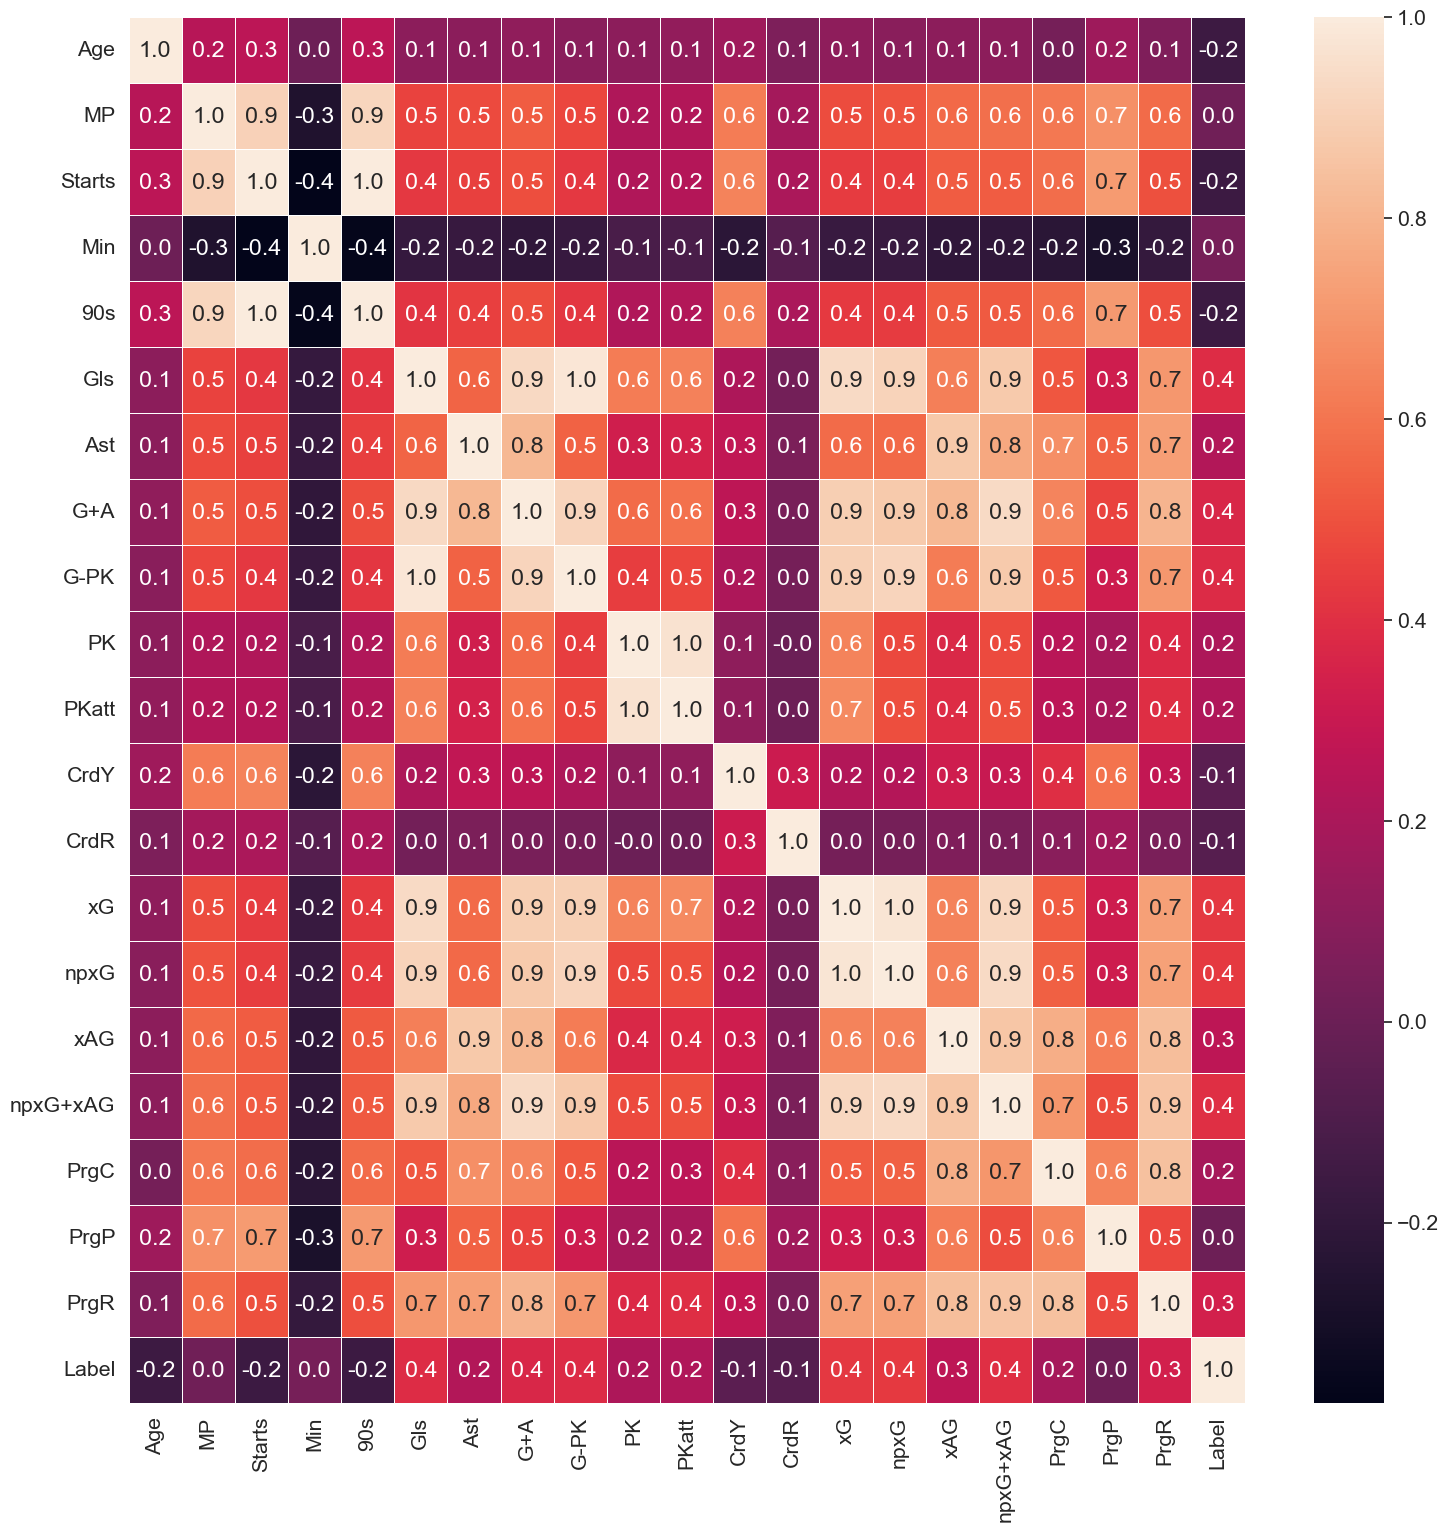

In [46]:
f, ax = plt.subplots(figsize=(18,18))
sns.heatmap(df.corr(), annot = True, linewidths = 0.5, fmt = '.1f', ax = ax)
plt.savefig('correlation_matrix')

In [17]:
#If more than one position listed, assume first position as preferred position
df['Pos'] = df['Pos'].str[:2]

In [18]:
df.dropna(inplace = True)

In [19]:
label_dict = {'GK': 0, 'DF': 1, 'MF': 2, 'FW': 3}

df['Label'] = df['Pos'].map(label_dict)

In [20]:
df.head()

,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,Min,...,CrdY,CrdR,xG,npxG,xAG,npxG+xAG,PrgC,PrgP,PrgR,Label
Rk,,,,,,,,,,,,,,,,,,,,,
1,Max Aarons,eng ENG,DF,Norwich City,eng Premier League,21,2000,34,32,2.881,...,8,0,0.8,0.8,1.7,2.5,78.0,117.0,85.0,1
2,Yunis Abdelhamid,ma MAR,DF,Reims,fr Ligue 1,33,1987,34,34,2.983,...,5,1,1.2,1.2,0.8,2.0,23.0,119.0,14.0,1
3,Salis Abdul Samed,gh GHA,MF,Clermont Foot,fr Ligue 1,21,2000,31,29,2.462,...,12,3,0.7,0.7,0.9,1.6,24.0,108.0,47.0,2
4,Laurent Abergel,fr FRA,MF,Lorient,fr Ligue 1,28,1993,34,34,2.956,...,9,0,1.5,1.5,3.7,5.1,30.0,171.0,73.0,2
5,Charles Abi,fr FRA,FW,Saint-Étienne,fr Ligue 1,21,2000,1,1,45.000,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3


In [33]:
df.dtypes

Player       object
Nation       object
Pos          string
Squad        object
Comp         object
Age           int64
Born         object
MP            int64
Starts        int64
Min         float64
90s         float64
Gls           int64
Ast           int64
G+A           int64
G-PK          int64
PK            int64
PKatt         int64
CrdY          int64
CrdR          int64
xG          float64
npxG        float64
xAG         float64
npxG+xAG    float64
PrgC        float64
PrgP        float64
PrgR        float64
Label         int64
dtype: object

In [22]:
df_selection = df.drop(['Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Born'], axis = 1)

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.tree import plot_tree
from sklearn.preprocessing import label_binarize
from itertools import cycle

In [24]:
rf = RandomForestClassifier(n_estimators = 50, min_samples_split = 10, random_state = 1)

In [25]:
x = df_selection.drop('Label', axis = 1)
y = df_selection['Label'].values

#y_bin = label_binarize(y, classes=[0, 1, 2, 3])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)

In [26]:
rf_classifier = RandomForestClassifier(n_estimators = 50, random_state = 1)

rf_classifier.fit(x_train, y_train)

y_pred = rf_classifier.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy}') 

Accuracy: 0.726027397260274


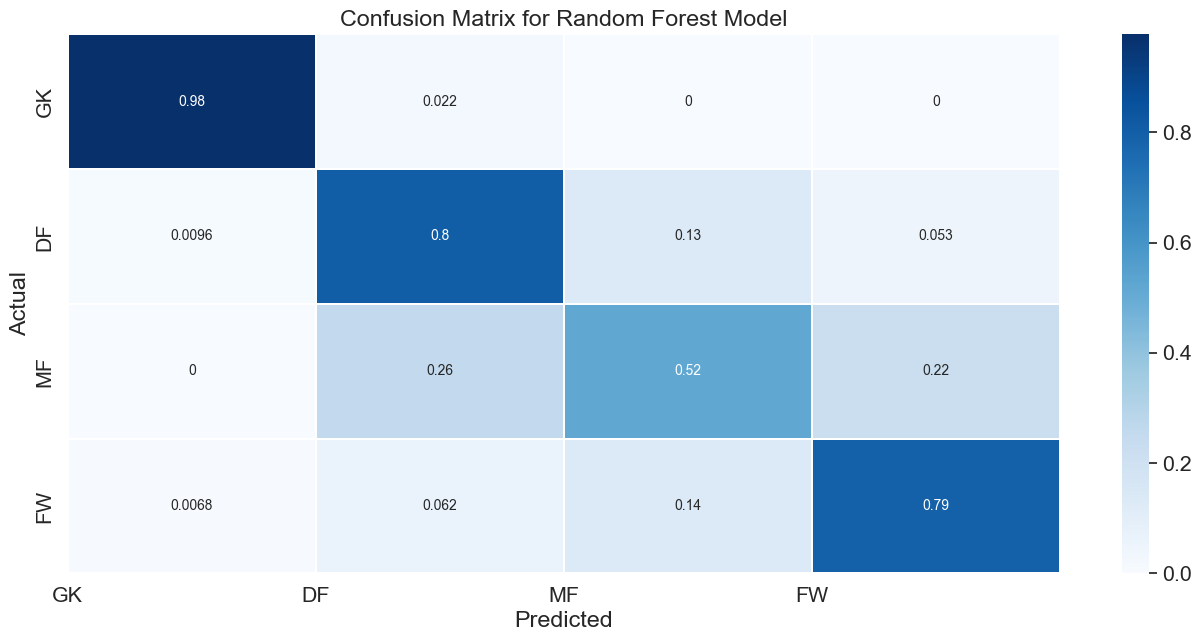

In [44]:
matrix = confusion_matrix(y_test, y_pred)

matrix = matrix.astype('float') / matrix.sum(axis = 1)[: , np.newaxis]

plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot = True, annot_kws = {'size':10}, cmap = plt.cm.Blues, linewidths = 0.2)

class_names = ['GK', 'DF', 'MF', 'FW']

tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks2, class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [28]:
feature_importance = rf_classifier.feature_importances_
feature_names = df_selection.columns.values[:-1]

sorted_idx = np.argsort(feature_importance)

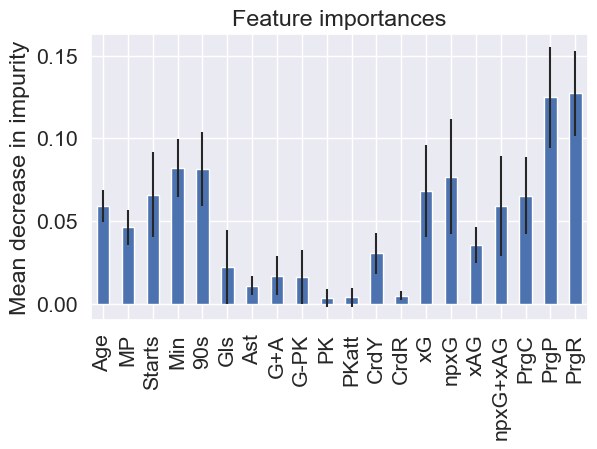

In [43]:
importances = rf_classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_classifier.estimators_], axis = 0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

plt.savefig('feature_importances.png')

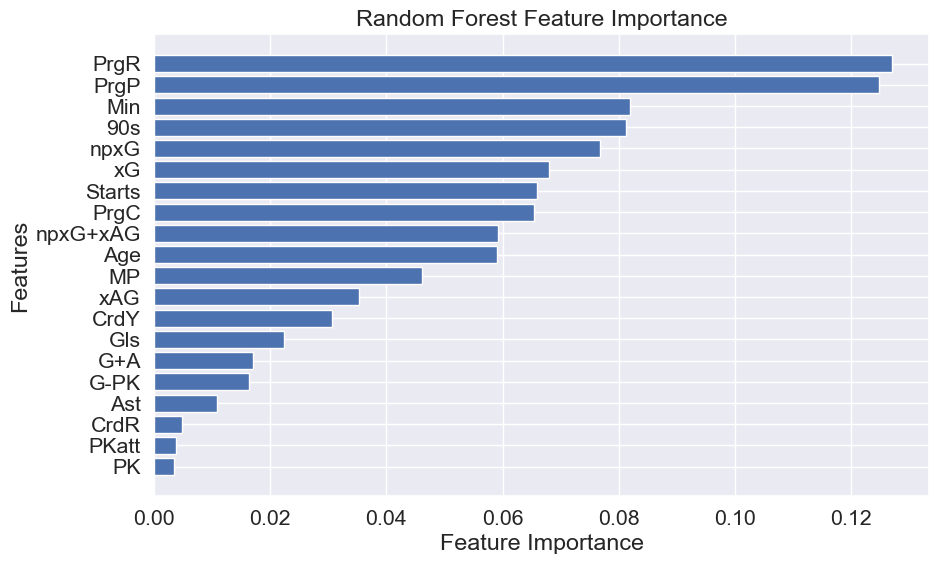

In [30]:
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance[sorted_idx])
plt.yticks(range(len(feature_importance)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Random Forest Feature Importance')
plt.show()

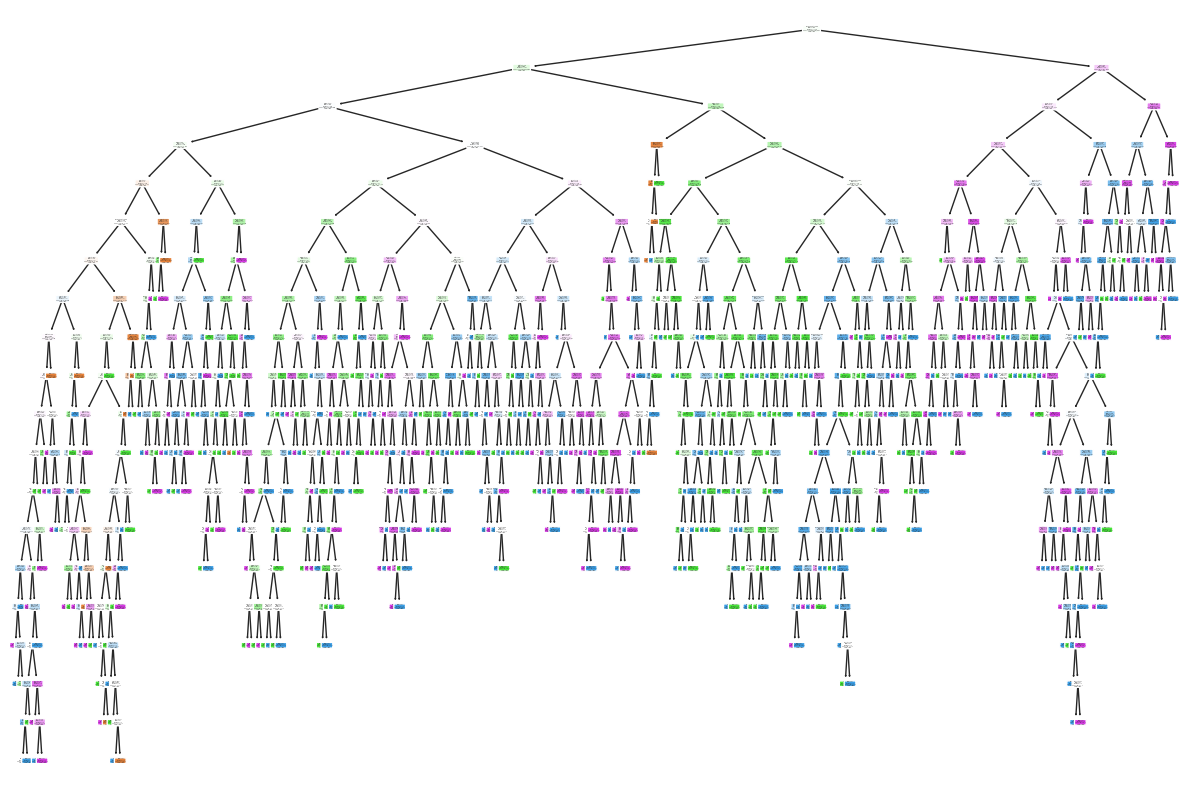

In [31]:
class_names = {v: k for k, v in label_dict.items()}
plt.figure(figsize=(15,10))
plot_tree(rf_classifier.estimators_[0], feature_names = feature_names, class_names  = [class_names[i] for i in range(len(class_names))], filled = True, rounded = True)
plt.show()

In [32]:
import pickle
pickle_out = open("classifier.pkl","wb")
pickle.dump(rf_classifier, pickle_out)
pickle_out.close()